<h1 style="text-align:center;">Assignment 2</h1>

<div class="alert alert-block alert-info" style="text-align:center;">
    <p style="text-align:center;"><b>Part 3:</b> Theoretically, increasing the number of decision trees (n_estimators), increases classifier performance and/or generalizability. How would you design and evaluate a computational experiment to test this, at least on the Titanic dataset?</p>
</div>

#### Table of Contents:

1. [Library Imports](#1.-Library-Imports)
2. [Reading Data into Notebook](#2.-Reading-Data-into-Notebook)
3. [Train - Test Split](#3.-Train---Test-Split)  
4. [Random Forest: Model Training, Tuning, and Evaluation](#4.-Random-Forest:-Model-Training,-Tuning,-and-Evaluation)  
5. [Testing Model on Test Dataset](#5.-Testing-Model-on-Test-Dataset)  
6. [Conclusion](#6.-Conclusion)


---

## 1. Library Imports

In [1]:
import pandas as pd
import numpy as np
from pandas.api.types import is_string_dtype,is_numeric_dtype
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, matthews_corrcoef, f1_score
from sklearn.model_selection import train_test_split
from sklearn.externals import joblib
from matplotlib import pyplot as plt
import seaborn as sns
import joblib

%matplotlib inline

C:\Users\srush\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
#Check the path to the directory where you are currently in
# Commenting for Git, providign direct path
#%pwd

In [3]:
# Commenting for Git, providign direct path
#my_path = 'C:\\Users\\srush\\Documents\\Srushti NEU\\Full Summer 2020\\INFO 6105 Data Science Engineering Methods and Tools\\Assignment\\Assignment 2'

[Scroll Top](#Assignment-2)

---

## 2. Reading Data into Notebook

In [4]:
# We will use the Titanic dataset, as supplied here (Titanic_full.csv).

df = pd.read_csv('DataSet/Titanic_full.csv')
print(df.shape)
df.head(3)

(1309, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
PassengerId    1309 non-null int64
Survived       1309 non-null int64
Pclass         1309 non-null int64
Name           1309 non-null object
Sex            1309 non-null object
Age            1046 non-null float64
SibSp          1309 non-null int64
Parch          1309 non-null int64
Ticket         1309 non-null object
Fare           1308 non-null float64
Cabin          295 non-null object
Embarked       1307 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 122.8+ KB


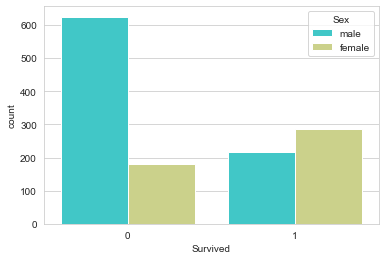

In [6]:
#Count Plot between Survived and its count differentiated by with Sex 
sns.set_style('whitegrid')
sns.countplot(x='Survived',hue='Sex',data=df,palette='rainbow')

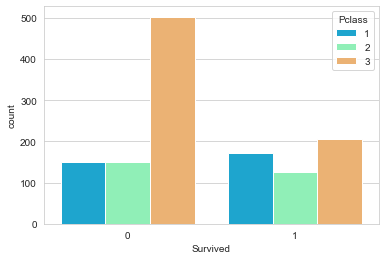

In [7]:
#Count Plot between Survived and its count differentiated by with PClass 
sns.set_style('whitegrid')
sns.countplot(x='Survived',hue='Pclass',data=df,palette='rainbow')

[Scroll Top](#Assignment-2)

---

## 3. Train - Test Split

In [8]:
# Keep aside test data first

def mydf_splitter(my_df,num_rows):
    return my_df[:num_rows].copy(),my_df[num_rows:]


df_trn_val,df_tst = mydf_splitter(df,1150)

print(df_trn_val.shape,df_tst.shape)

(1150, 12) (159, 12)


In [9]:
# Drop "Name","Cabin","Ticket" columns
df_trn_val1 = df_trn_val.drop(["Name","Cabin","Ticket"],axis = 1)
print(df_trn_val1.shape)
df_trn_val1.head(3)

(1150, 9)


,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,3,male,22.0,1,0,7.2500,S
1,2,1,1,female,38.0,1,0,71.2833,C
2,3,1,3,female,26.0,0,0,7.9250,S


#### Percentage of null  values

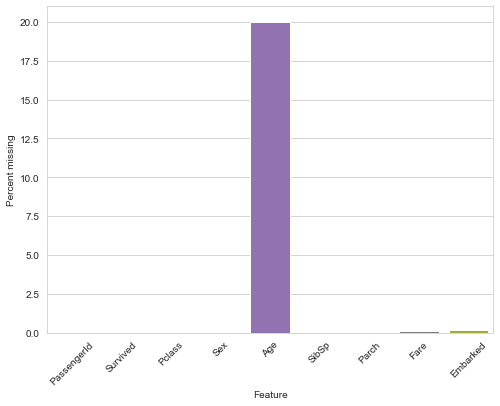

In [10]:
# Deal with missing values. First, calculate the percentage of missing values for every column, and plot them as a bar chart

null_vals = df_trn_val1.isnull().sum()/len(df_trn_val1)*100
null_vals = pd.DataFrame(null_vals)
null_vals.reset_index(inplace = True)
null_vals.columns = ["Feature","Percent missing"]
plt.figure(figsize = (8,6))
plt.xticks(rotation=45)
sns.barplot(x = "Feature",y ="Percent missing",data = null_vals)

In [11]:
#Define a function to convert object types and string types to category type

def str_to_cat(my_df):
    for p,q in my_df.items(): #my_df.items() is a generator in Python
        if is_string_dtype(q): 
            my_df[p] = q.astype('category').cat.as_ordered()
    return my_df

In [12]:
def mydf_to_nums(my_df, feature, null_status):
    if not is_numeric_dtype(feature):
        my_df[null_status] = feature.cat.codes + 1
        
def mydf_imputer(my_df, feature, null_status, null_table):
    if is_numeric_dtype(feature):
        if pd.isnull(feature).sum() or (null_status in null_table):
            my_df[null_status+'_na'] = pd.isnull(feature)
            filler = null_table[null_status] if null_status in null_table else feature.median()
            my_df[null_status] = feature.fillna(filler)
            null_table[null_status] = filler
    return null_table   

def mydf_preprocessor(my_df, null_table):
    '''null_table  = your table or None'''
    
    if null_table is None: 
        null_table = dict()
    for p,q in my_df.items(): 
        null_table = mydf_imputer(my_df, q, p, null_table)
    for p,q in my_df.items(): 
        mydf_to_nums(my_df, q, p)
    my_df = pd.get_dummies(my_df, dummy_na = True)
    res = [my_df, null_table]
    return res

In [13]:
df_trn_val2 = str_to_cat(df_trn_val1)
print(df_trn_val2.shape)
df_trn_val2.head(3)

(1150, 9)


,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,3,male,22.0,1,0,7.2500,S
1,2,1,1,female,38.0,1,0,71.2833,C
2,3,1,3,female,26.0,0,0,7.9250,S


In [14]:
df_trn_val3,my_table = mydf_preprocessor(df_trn_val2,null_table = None)
print(df_trn_val3.shape)
df_trn_val3.head(3)

(1150, 11)


,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Age_na,Fare_na
0,1,0,3,2,22.0,1,0,7.2500,3,False,False
1,2,1,1,1,38.0,1,0,71.2833,1,False,False
2,3,1,3,1,26.0,0,0,7.9250,3,False,False


In [15]:
my_table

{'Age': 28.0, 'Fare': 14.4542}

In [16]:
x = df_trn_val3.drop('Survived', axis=1)
y = df_trn_val3['Survived']

In [17]:
x_trn, x_val, y_trn, y_val = train_test_split(x, y, random_state=1)
print(x_trn.shape,x_val.shape,y_trn.shape,y_val.shape)

(862, 10) (288, 10) (862,) (288,)


[Scroll Top](#Assignment-2)

---

## 4. Random Forest: Model Training, Tuning, and Evaluation

In [18]:
# Checking n_estimators and accuracy, from 1 to 700 and skipping 50

n_est = list()
accuracy_list = list()


for n_estimators in range(1,700,50):
    rfc1 = RandomForestClassifier(n_estimators=n_estimators)
    rfc1.fit(x_trn,y_trn)
    y_pred = rfc1.predict(x_val)
    accuracy = accuracy_score(y_val,y_pred)
    n_est.append(n_estimators)
    accuracy_list.append(accuracy)

In [19]:
eval_df1 =  pd.DataFrame({"n_estimators": n_est,"Valid accuracy Score": accuracy_list})
eval_df1

,n_estimators,Valid accuracy Score
0,1,0.684028
1,51,0.739583
2,101,0.753472
3,151,0.739583
4,201,0.736111
5,251,0.736111
6,301,0.746528
7,351,0.739583
8,401,0.743056
9,451,0.750000


In [20]:
n_est = list()
accuracy_list = list()

# Checking n_estimators and accuracy, from 1 to 300 and skipping 20

for n_estimators in range(1,300,20):
    rfc2 = RandomForestClassifier(n_estimators=n_estimators)
    rfc2.fit(x_trn,y_trn)
    y_pred = rfc2.predict(x_val)
    accuracy = accuracy_score(y_val,y_pred)
    n_est.append(n_estimators)
    accuracy_list.append(accuracy)

In [21]:
eval_df2 =  pd.DataFrame({"n_estimators": n_est,"Valid accuracy Score": accuracy_list})
eval_df2

,n_estimators,Valid accuracy Score
0,1,0.729167
1,21,0.746528
2,41,0.746528
3,61,0.732639
4,81,0.739583
5,101,0.743056
6,121,0.743056
7,141,0.732639
8,161,0.750000
9,181,0.750000


In [22]:
rfc2 = RandomForestClassifier(n_estimators = 181)
rfc2.fit(x_trn, y_trn)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=181,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [23]:
y_prd_val = rfc2.predict(x_val)

print("\nValidation Set Accuracy Score")
print(accuracy_score(y_val,y_prd_val))


Validation Set Accuracy Score
0.7430555555555556


[Scroll Top](#Assignment-2)

---

## 5. Testing Model on Test Dataset

#### Preprocess test set exactly like the train and validation sets

In [24]:
df_tst1 = df_tst.drop(["Name","Cabin","Ticket"],axis = 1)
print(df_tst1.shape)
df_tst1.head(3)

(159, 9)


,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
1150,1151,1,3,male,21.0,0,0,7.7750,S
1151,1152,0,3,male,36.5,1,0,17.4000,S
1152,1153,1,3,male,21.0,0,0,7.8542,S


In [25]:
# Calling String to category function
df_tst2 = str_to_cat(df_tst1)
df_tst2.Sex.cat.categories

Index(['female', 'male'], dtype='object')

In [26]:
# Calling mydf_preprocessor function
df_tst2,my_table1 = mydf_preprocessor(df_tst1, null_table = my_table)
print(df_tst2.shape)
df_tst2.head(3)

(159, 11)


,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Age_na,Fare_na
1150,1151,1,3,2,21.0,0,0,7.7750,3,False,False
1151,1152,0,3,2,36.5,1,0,17.4000,3,False,False
1152,1153,1,3,2,21.0,0,0,7.8542,3,False,False


In [27]:
# Now, let's split out the X and Y variables (vertical split of the dataframe)

y_tst = df_tst2["Survived"]
x_tst = df_tst2.drop(["Survived"],axis = 1)

print(x_tst.shape,y_tst.shape)

(159, 10) (159,)


In [28]:
y_prd_tst = rfc2.predict(x_tst)
accuracy_score(y_tst,y_prd_tst)

0.5534591194968553

In [29]:

#Calculating accuracy on trained model

print("\nAccuracy Score")
print(accuracy_score(y_tst,y_prd_tst))

print("\nMatthews Corrcoef")
print(matthews_corrcoef(y_tst,y_prd_tst))
      
print("\nF1 Score")
print(f1_score(y_tst,y_prd_tst))


Accuracy Score
0.5534591194968553

Matthews Corrcoef
0.0981778895363389

F1 Score
0.5034965034965034


[Scroll Top](#Assignment-2)

---

## 6. Conclusion

Hence, we can conclude that increasing the number of decision trees (n_estimators), increases classifier performance and/or generalizability.

[Scroll Top](#Assignment-2)

---

<div class="alert alert-block alert-info">
    <b>Copyright</b> 2020 Srushti Dhamangaonkar<br>
    <br>Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:<br>
    <br>The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.<br>
    <br>THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.
    <br><br>
    
<div class="text-center">
    <a rel="license" href="http://creativecommons.org/licenses/by/3.0/us/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by/3.0/us/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by/3.0/us/">Creative Commons Attribution 3.0 United States License</a>.<br>
</div></div>